In [1]:
import numpy as np 
from utils import read_dataset, drop_useless
import os 

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
SUBJECT = "Finn"

dataset = read_dataset(SUBJECT,
                       # timestamp="10-12-24",
                       read_ort=False)
for nd in dataset:
    nd.fill(1.0)
dataset = drop_useless(dataset)
for nd in dataset: 
    nd.moving_average_filter(30, on="emg")
    nd.moving_average_filter(10, on="joints")

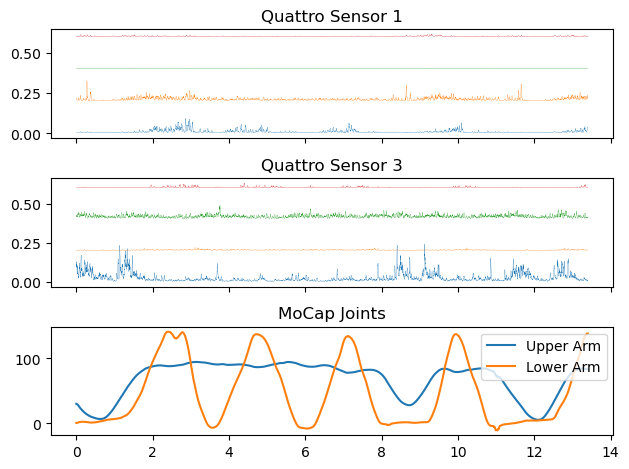

In [3]:
dataset[0].plot(plot_emg=True, plot_mocap_joints=True)

In [4]:
from numpy.lib.stride_tricks import sliding_window_view

def prepare_data_narx(n: int, data, lstm_ready: bool=True): 
    joints = data[0][:, -1, :]
    past = sliding_window_view(joints, (n, 2))
    if lstm_ready: 
        past = past.reshape(-1, n, 2)
    else: 
        past = past.reshape(-1, n*2)
    return data[-1][n:], joints[n:], past[:-1]

In [5]:
# prepare data: windowed emg data [..., 222, 8]: 222 Samples per win ~ 0.1sec = 100msec, 8 channels
# corresponding target: joint data [..., 2]: 2 joints Flexion/Extension and Pronation/Supination
# past joints: n - past joints (for narx) [..., 8]: 4 (n past samples) * 2 joints = 8 
# targets is 50 ms ahead of everything else

n_win = 10
emg_data, joints, past_joints = zip(*[prepare_data_narx(4, d.get_data(n_win, n_win, 222, n_win/2)) for d in dataset])

In [6]:
# norm emg: cumbersome, but needed to keep the chronical order
emg_max, emg_min = max(ed.max() for ed in emg_data), min(ed.min() for ed in emg_data)
emg_data = [(ed - emg_min) / (emg_max - emg_min) for ed in emg_data]
emg_max, emg_min

(np.float32(1.3130887), np.float32(2.4274932e-05))

In [7]:
# norm joints 
joints_max, joints_min = max(x.max() for x in past_joints), min(x.min() for x in past_joints)
joints = [(jd - joints_min) / (joints_max - joints_min) for jd in joints]
past_joints = [(pj - joints_min) / (joints_max - joints_min) for pj in past_joints]
joints_max, joints_min

(np.float32(157.01103), np.float32(-28.994228))

In [8]:

def make_batches(*sets, batch_size: int, drop_remainder: bool or int):
    """
    batches data by batch size 
    drop remainder can either be:
        True -- remaining windows that doesn't fit batch size will be dropped 
        False -- remaining windows will be kept 
        int -- remaining data needs to be as many as drop_remainder to be kept: typical would be batch_size/2
    Small batches lead to too much weight on that batch, drop data loses data 
    """
    if type(drop_remainder) == bool: 
        if drop_remainder: 
            drop_remainder = batch_size
        else: 
            drop_remainder = 0
    batches = []
    for data in zip(*sets): 
        split = data[0].shape[0] % batch_size
        batches_win = [[], [], []]
        for i, d in enumerate(data): 
            if not split: 
                batches_win[i] += list(d.reshape(-1, batch_size, *d.shape[1:]))
                continue
            full, remainder = np.split(d, (-split, ))
            if full.shape[0]: 
                full = list(full.reshape(-1, batch_size, *full.shape[1:]))
                batches_win[i] += full
            if remainder.shape[0] > drop_remainder:
                remainder = list(remainder[np.newaxis])
                batches_win[i] += remainder
        batches += list(zip(*batches_win))
    return batches

batches = make_batches(emg_data, joints, past_joints, batch_size=32, drop_remainder=16)

In [9]:
# 5970 batches of 32 windows each a tuple of 3 (emg, joints, past_joints) -> ((32, 222, 8), (32, 2), (32, 4, 2)) and remainder batches
len(batches), len(batches[0]), batches[0][2].shape

(6741, 3, (32, 4, 2))

In [10]:
# shuffle batches but keep time constraint inside each batch
np.random.seed(10)
indices = np.arange(len(batches))
np.random.shuffle(indices)
batches = [batches[i] for i in indices]

In [11]:
# Split into train, test and val data -> splits based on amount of windows

total_wins = sum(batch[0].shape[0] for batch in batches)
cur_win = 0
train_data, val_data, test_data = [], [], []
for batch in batches: 
    cur_win += batch[0].shape[0]
    if cur_win < 0.7 * total_wins: 
        train_data.append(batch)
    elif total_wins * 0.7 <= cur_win < total_wins * 0.85: 
        test_data.append(batch)
    else: 
        val_data.append(batch)

len(train_data), len(train_data[0]), train_data[0][0].shape

(4720, 3, (32, 222, 8))

In [12]:
def sample_train_loop(f_batches):
    _, _, train_past_joints = zip(*f_batches)
    train_past_joints = list(train_past_joints)
    for i, (f_emg, f_joints, f_past_joints) in enumerate(f_batches): 
        # model predict (f_emg, train_past_joints[i])
        pred = f_joints + (np.random.random(f_joints.shape) * 0.1 - 0.05)
        # update model etc 
        sampler = np.where(np.random.random(pred.shape) < 0.5, f_joints, pred)
        sampler = sliding_window_view(sampler, (4, 2)).reshape(-1, 4, 2)
        train_past_joints[i] = np.vstack((f_past_joints[:4], sampler[:-1]))
        # See how they are randomly sampled 
        print(f_past_joints[:5, :, 0])
        print(train_past_joints[i][:5, :, 0])
        break

sample_train_loop(train_data)

[[0.61601275 0.61884856 0.6195582  0.62130183]
 [0.61884856 0.6195582  0.62130183 0.62571365]
 [0.6195582  0.62130183 0.62571365 0.6304985 ]
 [0.62130183 0.62571365 0.6304985  0.6347753 ]
 [0.62571365 0.6304985  0.6347753  0.63792753]]
[[0.61601275 0.61884856 0.61955822 0.62130183]
 [0.61884856 0.61955822 0.62130183 0.62571365]
 [0.61955822 0.62130183 0.62571365 0.63049853]
 [0.62130183 0.62571365 0.63049853 0.63477528]
 [0.58505432 0.63049853 0.63477528 0.64796258]]


In [13]:
# Define model 

from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense, LSTM, Input, concatenate
from keras.optimizers import Adam

emg_features = Sequential()
emg_features.add(Input((222, 8)))
emg_features.add(LSTM(32, return_sequences=True))
emg_features.add(Dropout(0.2))
emg_features.add(LSTM(16))
emg_features.add(Dense(16, activation="relu"))
emg_features.add(Dense(8, activation="relu"))

E0000 00:00:1736931312.814457    8252 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736931312.816582    8252 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1736931313.702038    8252 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9726 MB memory:  -> device: 0, name: NVIDIA RTX A2000 12GB, pci bus id: 0000:01:00.0, compute capability: 8.6


In [14]:
emg_features.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 222, 32)        │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 222, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,792 (34.34 KB)

 Trainable params: 8,792 (34.34 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
input1 = Input(shape=(222,8))
output1 = emg_features(input1)

In [16]:
past_features = Sequential()
past_features.add(Input((4, 2)))
past_features.add(LSTM(4))
past_features.add(Dropout(0.2))
past_features.add(Dense(8))
past_features.add(Dense(4))

past_features.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 4)              │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 188 (752.00 B)

 Trainable params: 188 (752.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
input2 = Input(shape=(4, 2))
output2 = past_features(input2)

merged = concatenate([output1, output2])
layer = Dense(8, activation="relu")(merged)
final_output = Dense(2, activation="relu")(layer)

In [18]:
model = Model(inputs=[input1, input2], outputs=final_output)
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 222, 8)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 4, 2)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 8)         │      8,792 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 4)         │        188 │ input_layer_3[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 12)        │          0 │ sequential[0][0], │
│ (Concatenate)       │                   │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 8)         │        104 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 2)         │         18 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,102 (35.55 KB)

 Trainable params: 9,102 (35.55 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
def train_teacher_forcing(m, t_data, v_data): 
    m.compile(optimizer=Adam(learning_rate=5e-4), loss="mse")
    train_emg, y_train, train_past_j = (np.vstack(x) for x in zip(*t_data))
    val_emg, y_val, val_past_j = (np.vstack(x) for x in zip(*v_data))
    hist = m.fit((train_emg, train_past_j), y_train, epochs=100, batch_size=32, validation_data=((val_emg, val_past_j), y_val))
    return hist, m

In [ ]:
teacher_history, teacher_model = train_teacher_forcing(model, train_data, val_data)

Epoch 1/100
4678/4678 ━━━━━━━━━━━━━━━━━━━━ 103s 22ms/step - loss: 0.0046 - val_loss: 0.0011
Epoch 2/100
 225/4678 ━━━━━━━━━━━━━━━━━━━━ 1:29 20ms/step - loss: 0.0043

Teacher forcing vs scheduled sampling 

In [ ]:
import matplotlib.pyplot as plt 

history = np.genfromtxt(os.path.join(base_path, "history.csv"), delimiter=',')
plt.plot(history)
plt.show()